In [3]:
import torch
import torch.nn as nn
import os
import numpy as np
from torch.utils.data import DataLoader, TensorDataset
import torch.nn.functional as F
from torch.optim import Adam
from torch.optim.lr_scheduler import StepLR
import matplotlib.pyplot as plt
from torch.utils.data import Dataset, DataLoader

class SpectralConv1d(nn.Module):
    def __init__(self, in_channels, out_channels, modes1):
        super(SpectralConv1d, self).__init__()

        """
        1D Fourier layer. It does FFT, linear transform, and Inverse FFT.
        """

        self.in_channels = in_channels
        self.out_channels = out_channels
        self.modes1 = modes1

        self.scale = (1 / (in_channels * out_channels))
        self.weights1 = nn.Parameter(self.scale * torch.rand(in_channels, out_channels, self.modes1, dtype=torch.cfloat))

    # Complex multiplication
    def compl_mul1d(self, input, weights):
        # (batch, in_channel, x ), (in_channel, out_channel, x) -> (batch, out_channel, x)
        return torch.einsum("bix,iox->box", input, weights)

    def forward(self, x):
        batchsize = x.shape[0]
        # x.shape == [batch_size, in_channels, number of grid points]
        # hint: use torch.fft library torch.fft.rfft
        # use DFT to approximate the fourier transform

        # Compute Fourier coefficients
        x_ft = torch.fft.rfft(x)

        # Multiply relevant Fourier modes
        out_ft = torch.zeros(batchsize, self.out_channels, x.size(-1) // 2 + 1, device=x.device, dtype=torch.cfloat)
        out_ft[:, :, :self.modes1] = self.compl_mul1d(x_ft[:, :, :self.modes1], self.weights1)

        # Return to physical space
        x = torch.fft.irfft(out_ft, n=x.size(-1))
        return x


class FNO1d(nn.Module):
    def __init__(self, modes, width):
        super(FNO1d, self).__init__()

        """
        The overall network. It contains 4 layers of the Fourier layer.
        1. Lift the input to the desire channel dimension by self.fc0 .
        2. 4 layers of the integral operators u' = (W + K)(u).
            W defined by self.w;
            K defined by self.conv .
        3. Project from the channel space to the output space by self.fc1 and self.fc2 .

        input: the solution of the initial condition and location (a(x), x)
        input shape: (batchsize, x=s, c=2)
        output: the solution of a later timestep
        output shape: (batchsize, x=s, c=1)
        """

        self.modes1 = modes
        self.width = width
        self.padding = 1  # pad the domain if input is non-periodic
        self.linear_p = nn.Linear(2, self.width)  # input channel is 2: (u0(x), x) --> GRID IS INCLUDED!

        self.spect1 = SpectralConv1d(self.width, self.width, self.modes1)
        self.spect2 = SpectralConv1d(self.width, self.width, self.modes1)
        self.spect3 = SpectralConv1d(self.width, self.width, self.modes1)
        self.lin0 = nn.Conv1d(self.width, self.width, 1)
        self.lin1 = nn.Conv1d(self.width, self.width, 1)
        self.lin2 = nn.Conv1d(self.width, self.width, 1)

        self.linear_q = nn.Linear(self.width, 32)
        self.output_layer = nn.Linear(32, 1)

        self.activation = torch.nn.ReLU()

    def fourier_layer(self, x, spectral_layer, conv_layer):
        return self.activation(spectral_layer(x) + conv_layer(x))

    def linear_layer(self, x, linear_transformation):
        return self.activation(linear_transformation(x))

    def forward(self, x):
        #print("x1", x.shape)
        x = self.linear_p(x)
        #print("x2", x.shape)
        x = x.permute(0, 2, 1)
        # x = F.pad(x, [0, self.padding])  # pad the domain if input is non-periodic
        #print("x3", x.shape)
        x = self.fourier_layer(x, self.spect1, self.lin0)
        #print("x4", x.shape)
        x = self.fourier_layer(x, self.spect2, self.lin1)
        #print("x5", x.shape)
        x = self.fourier_layer(x, self.spect3, self.lin2)
        #print("x6", x.shape)
        # x = x[..., :-self.padding]  # pad the domain if input is non-periodic
        x = x.permute(0, 2, 1)
        #print("x7", x.shape)
        x = self.linear_layer(x, self.linear_q)
        #print("x8", x.shape)
        x = self.output_layer(x)
        #print("x9", x.shape)
        return x


torch.manual_seed(0)
np.random.seed(0)


n_train = 64 # number of training samples


# Load training solution data
train_data = np.load("train_sol.npy", allow_pickle=True)

# Extract first (t=0) and last (t=1) time snapshots
n_trajectories = train_data.shape[0]
n_spatial_points = train_data.shape[2]

# Initialize arrays for input (t=0) and output (t=1)
x_data = np.zeros((n_trajectories, n_spatial_points, 2))  # 2 for [u(t=0), x]
y_data = np.zeros((n_trajectories, n_spatial_points))     # u(t=1)

# Fill the arrays
for i in range(n_trajectories):
    x_data[i, :, 0] = train_data[i, 0, :]    # u(t=0)
    x_data[i, :, 1] = np.linspace(-1, 1, n_spatial_points)  # spatial grid
    y_data[i, :] = train_data[i, -1, :]      # u(t=1)

# Convert to PyTorch tensors
x_data = torch.from_numpy(x_data).type(torch.float32)
y_data = torch.from_numpy(y_data).type(torch.float32)
# we train on the first 64 samples, the rest remains for validation
input_function_train = x_data[:n_train, :]
output_function_train = y_data[:n_train, :]
# we want to get the l2 error on the remaining 64 but test the final result on all 128
input_function_val = x_data[n_train:, :]
output_function_val = y_data[n_train:, :]


batch_size = 8

training_set = DataLoader(TensorDataset(input_function_train, output_function_train), batch_size=batch_size, shuffle=True)
val_set = DataLoader(TensorDataset(input_function_val, output_function_val), batch_size=batch_size, shuffle=False)

id_sample = 32

# NOTE: THIS IS WHAT THE DATA LOOKS LIKE
#plt.plot(np.linspace(-1,1,input_function_train.shape[1]),input_function_train[id_sample,:,0], label = "input:   $u(t = 0)$")
#plt.plot(np.linspace(-1,1,input_function_train.shape[1]),output_function_train[id_sample,:], label = "output: $u(t = 1)$")
#plt.grid(True, which="both", ls=":")
#plt.legend()

modes = 10
width = 35
fno = FNO1d(modes, width) # model

# set up the optimizer
learning_rate = 0.0002
epochs = 250
optimizer = Adam(fno.parameters(), lr=learning_rate, weight_decay=1e-5)


l = torch.nn.MSELoss()
freq_print = 5
for epoch in range(epochs):
    fno.train()
    train_mse = 0.0
    for step, (input_batch, output_batch) in enumerate(training_set):
        optimizer.zero_grad()
        output_pred_batch = fno(input_batch).squeeze(2)
        loss_f = l(output_pred_batch, output_batch)
        loss_f.backward()
        optimizer.step()
        train_mse += loss_f.item()
    train_mse /= len(training_set)


    with torch.no_grad():
        fno.eval()
        val_relative_l2 = 0.0
        for step, (input_batch, output_batch) in enumerate(val_set):
            output_pred_batch = fno(input_batch).squeeze(2)
            loss_f = (torch.mean((output_pred_batch - output_batch) ** 2) / torch.mean(output_batch ** 2)) ** 0.5 * 100
            val_relative_l2 += loss_f.item()
        val_relative_l2 /= len(val_set)

    if epoch % freq_print == 0: print("######### Epoch:", epoch, " ######### Train Loss:", train_mse, " ######### Relative L2 val Norm:", val_relative_l2)




######### Epoch: 0  ######### Train Loss: 0.035816004732623696  ######### Relative L2 val Norm: 101.94919776916504
######### Epoch: 5  ######### Train Loss: 0.027964607579633594  ######### Relative L2 val Norm: 93.91676616668701
######### Epoch: 10  ######### Train Loss: 0.022903749253600836  ######### Relative L2 val Norm: 83.9538927078247
######### Epoch: 15  ######### Train Loss: 0.01660506008192897  ######### Relative L2 val Norm: 70.62202072143555
######### Epoch: 20  ######### Train Loss: 0.00822737521957606  ######### Relative L2 val Norm: 49.51089334487915
######### Epoch: 25  ######### Train Loss: 0.004071193252457306  ######### Relative L2 val Norm: 35.60015249252319
######### Epoch: 30  ######### Train Loss: 0.0028869333618786186  ######### Relative L2 val Norm: 31.92207098007202
######### Epoch: 35  ######### Train Loss: 0.002314206925802864  ######### Relative L2 val Norm: 29.410589456558228
######### Epoch: 40  ######### Train Loss: 0.0019784521573456004  ######### Relati

In [5]:
# test on the testing set
test_data = np.load("test_sol.npy", allow_pickle=True)

n_trajectories_test = test_data.shape[0]

x_data_test = np.zeros((n_trajectories_test, n_spatial_points, 2))  # 2 for [u(t=0), x]
y_data_test = np.zeros((n_trajectories_test, n_spatial_points))     # u(t=1)
for i in range(n_trajectories_test):
    x_data_test[i, :, 0] = test_data[i, 0, :]    # u(t=0)
    x_data_test[i, :, 1] = np.linspace(-1, 1, n_spatial_points)  # spatial grid
    y_data_test[i, :] = test_data[i, -1, :]      # u(t=1)

x_data_test = torch.from_numpy(x_data_test).type(torch.float32)
y_data_test = torch.from_numpy(y_data_test).type(torch.float32)

testing_set = DataLoader(TensorDataset(x_data_test, y_data_test), batch_size=batch_size, shuffle=False)

fno.eval()

with torch.no_grad():
    test_relative_l2 = 0.0
    for step, (input_batch, output_batch) in enumerate(testing_set):
        output_pred_batch = fno(input_batch).squeeze(2)
        loss_f = (torch.mean((output_pred_batch - output_batch) ** 2) / torch.mean(output_batch ** 2)) ** 0.5 * 100
        test_relative_l2 += loss_f.item()
    test_relative_l2 /= len(testing_set)
    
print("Relative L2 norm on the testing set:", test_relative_l2)


Relative L2 norm on the testing set: 12.852337658405304


# TASK 2: Testing on Different Resolutions


relative error for res =  32
Relative L2 error:  13.779685974121094
relative error for res =  64
Relative L2 error:  12.714886665344238
relative error for res =  96
Relative L2 error:  12.25017261505127
relative error for res =  128
Relative L2 error:  13.368155479431152


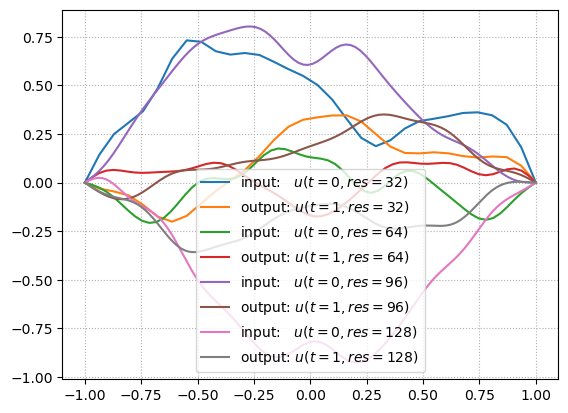

In [6]:
available_res = [32, 64, 96,128]

for res in available_res:
    #print("current res = ", res)
    # Load training solution data
    test_data = np.load(f"test_sol_res_{res}.npy", allow_pickle=True)



    # Extract first (t=0) and last (t=1) time snapshots
    n_trajectories_res = test_data.shape[0]
    n_spatial_points_res = test_data.shape[2]

    # Initialize arrays for input (t=0) and output (t=1)
    x_data = np.zeros((n_trajectories_res, n_spatial_points_res, 2))  # 2 for [u(t=0), x]
    y_data = np.zeros((n_trajectories_res, n_spatial_points_res))     # u(t=1)

    #print("x_data.shape: ", x_data.shape)

    # Fill the arrays
    for i in range(n_trajectories_res):

        x_data[i, :, 0] = test_data[i, 0, :]    # u(t=0)
        x_data[i, :, 1] = np.linspace(-1, 1, n_spatial_points_res)  # spatial grid
        y_data[i, :] = test_data[i, -1, :]      # u(t=1)
        # if i == 0:
        #     print("x_data[i, :, 0]: ", x_data[i, :, 0])
        #     print("x_data[i, :, 1]: ", x_data[i, :, 1])
        #     print("y_data[i, :]: ", y_data[i, :])

        #     print("test_data[i, :, :]: ", test_data[i, :, :])



    id_sample = 3
    plt.plot(np.linspace(-1,1,x_data.shape[1]),x_data[id_sample,:,0], label = f"input:   $u(t = 0, res = {res})$")
    plt.plot(np.linspace(-1,1,x_data.shape[1]),y_data[id_sample,:], label = f"output: $u(t = 1,res = {res})$")
    plt.grid(True, which="both", ls=":")
    plt.legend()
    plt.show

    # Convert to PyTorch tensors
    input_data_res = torch.from_numpy(x_data).type(torch.float32)
    true_output_res = torch.from_numpy(y_data).type(torch.float32)


    pred_output_res = fno(input_data_res)

    print("relative error for res = " , res )
    p = 2
    err = (torch.mean(abs(true_output_res.detach().reshape(-1, ) - pred_output_res.detach().reshape(-1, )) ** p) / torch.mean(abs(true_output_res.detach()) ** p)) ** (1 / p) * 100
    print("Relative L2 error: ", err.item())



# Task 3: Testing on Out-of-Distribution (OOD) Dataset

x_data.shape:  (128, 64, 2)
Relative L2 error for OOD data:  16.36255645751953


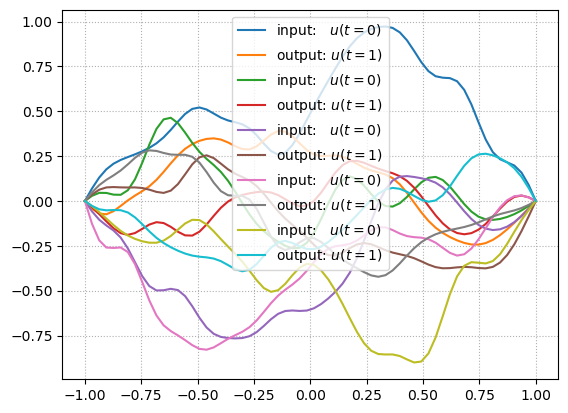

In [3]:
# TASK 3 OOD data


test_data = np.load(f"test_sol_OOD.npy", allow_pickle=True)



# Extract first (t=0) and last (t=1) time snapshots
n_trajectories_ood = test_data.shape[0]
n_spatial_points_ood = test_data.shape[2]

# Initialize arrays for input (t=0) and output (t=1)
x_data = np.zeros((n_trajectories_ood, n_spatial_points_ood, 2))  # 2 for [u(t=0), x]
y_data = np.zeros((n_trajectories_ood, n_spatial_points_ood))     # u(t=1)

print("x_data.shape: ", x_data.shape)

# Fill the arrays
for i in range(n_trajectories_ood):
    x_data[i, :, 0] = test_data[i, 0, :]    # u(t=0)
    x_data[i, :, 1] = np.linspace(-1, 1, n_spatial_points_ood)  # spatial grid
    y_data[i, :] = test_data[i, -1, :]      # u(t=1)

for id_sample in range(5):
    plt.plot(np.linspace(-1,1,x_data.shape[1]),x_data[id_sample,:,0], label = f"input:   $u(t = 0)$")
    plt.plot(np.linspace(-1,1,x_data.shape[1]),y_data[id_sample,:], label = f"output: $u(t = 1)$")
    plt.grid(True, which="both", ls=":")
plt.legend()
plt.show

# Convert to PyTorch tensors
input_data_ood = torch.from_numpy(x_data).type(torch.float32)
true_output_ood = torch.from_numpy(y_data).type(torch.float32)


pred_output_ood = fno(input_data_ood)

p = 2
err = (torch.mean(abs(true_output_ood.detach().reshape(-1, ) - pred_output_ood.detach().reshape(-1, )) ** p) / torch.mean(abs(true_output_ood.detach()) ** p)) ** (1 / p) * 100
print("Relative L2 error for OOD data: ", err.item())


# Task 4: All2All Training

time-dependent fno for the 4th and 5th subtasks.

In [18]:
class generate_training_dataset(Dataset):
    def __init__(self, training_samples=64):
        self.data = np.load("train_sol.npy")

        #print("Data shape: ", self.data.shape)

        self.N = self.data.shape[0]  # number of trajectories
        self.T = self.data.shape[1]  # number of time steps
        self.S = self.data.shape[2]  # number of spatial points

        # Use only the specified number of training samples
        self.data = self.data[:training_samples]

        # Precompute all possible (t_initial, t_final) pairs
        self.time_pairs = [(i, j) for i in range(self.T) for j in range(i + 1, self.T)]
        #self.time_pairs = [(0, 4)]
        self.len_times = len(self.time_pairs)
        print("nr of time pairs: ", self.len_times)

        # Total length is number of samples times number of time pairs
        self.length = training_samples * self.len_times

        self.mean = np.mean(self.data)
        self.std = np.std(self.data)

    def __len__(self):
        return self.length

    def __getitem__(self, index):
        # Calculate which trajectory and which time pair to use
        sample_idx = index // self.len_times
        time_pair_idx = index % self.len_times
        #print("sample index, time_pair index", sample_idx, time_pair_idx)

        t_inp, t_out = self.time_pairs[time_pair_idx]
        delta_time = (t_out - t_inp) * 0.25  # Scale time to [0,1]

        # Normalize input and output
        # inp_data = (self.data[sample_idx, t_inp] - self.mean) / self.std
        # out_data = (self.data[sample_idx, t_out] - self.mean) / self.std

        inp_data = self.data[sample_idx, t_inp]
        out_data = self.data[sample_idx, t_out]
        inputs = torch.from_numpy(inp_data).type(torch.float32)
        inputs_t = torch.ones_like(inputs) * delta_time
        inputs = torch.stack((inputs, inputs_t), dim=1)

        outputs = torch.from_numpy(out_data).type(torch.float32)
        return delta_time, inputs, outputs


class generate_test_dataset(Dataset):
    def __init__(self):
        self.data = np.load("test_sol.npy")

        #print("Data shape: ", self.data.shape)

        self.N = self.data.shape[0]
        self.T = self.data.shape[1]
        self.S = self.data.shape[2]

        self.mean = np.mean(self.data)
        self.std = np.std(self.data)

    def __len__(self):
        return self.N

    def __getitem__(self, index):
        delta_time = 1.0
        
        #inp_data = (self.data[index, 0] - self.mean) / self.std
        #out_data = (self.data[index, -1] - self.mean) / self.std
        inp_data = self.data[index, 0]
        out_data = self.data[index, -1]

        inputs = torch.from_numpy(inp_data).type(torch.float32)
        inputs_t = torch.ones_like(inputs).type(torch.float32) * 1
        inputs = torch.stack((inputs, inputs_t), 1)

        outputs = torch.from_numpy(self.data[index, -1]).type(torch.float32)
        return delta_time, inputs, outputs


In [19]:

#---------------------
# Time-conditional BN:
#---------------------

class FILM(torch.nn.Module):
    def __init__(self,
                channels,
                use_bn = True):
        super(FILM, self).__init__()
        self.channels = channels

        self.inp2scale = nn.Linear(in_features=1, out_features=channels, bias=True)
        self.inp2bias = nn.Linear(in_features=1, out_features=channels, bias=True)

        self.inp2scale.weight.data.fill_(0)
        self.inp2scale.bias.data.fill_(1)
        self.inp2bias.weight.data.fill_(0)
        self.inp2bias.bias.data.fill_(0)

        if use_bn:
          self.norm = nn.BatchNorm1d(channels)
        else:
          self.norm = nn.Identity()

    def forward(self, x, time):

        x = self.norm(x)
        time = time.reshape(-1,1).type_as(x)

        scale     = self.inp2scale(time)
        bias      = self.inp2bias(time)
        scale = scale.unsqueeze(2).expand_as(x)
        bias  = bias.unsqueeze(2).expand_as(x)
        return x * scale + bias



In [20]:
class tdFNO1d(nn.Module):
    def __init__(self, modes, width, dropout_prob = 0.1):
        super(tdFNO1d, self).__init__()

        """
        The overall network. It contains 4 layers of the Fourier layer.
        1. Lift the input to the desire channel dimension by self.fc0 .
        2. 4 layers of the integral operators u' = (W + K)(u).
            W defined by self.w;
            K defined by self.conv .
        3. Project from the channel space to the output space by self.fc1 and self.fc2 .

        input: the solution of the initial condition and location (a(x), x)
        input shape: (batchsize, x=s, c=2)
        output: the solution of a later timestep
        output shape: (batchsize, x=s, c=1)
        """

        self.modes1 = modes
        self.width = width
        self.padding = 1  # pad the domain if input is non-periodic
        self.linear_p = nn.Linear(2, self.width)  # input channel is 2: (u0(x), x) --> GRID IS INCLUDED!

        self.spect1 = SpectralConv1d(self.width, self.width, self.modes1)
        self.spect2 = SpectralConv1d(self.width, self.width, self.modes1)
        self.spect3 = SpectralConv1d(self.width, self.width, self.modes1)
        self.lin0 = nn.Conv1d(self.width, self.width, 1)
        self.lin1 = nn.Conv1d(self.width, self.width, 1)
        self.lin2 = nn.Conv1d(self.width, self.width, 1)

        self.linear_q = nn.Linear(self.width, 32)
        self.output_layer = nn.Linear(32, 1)

        self.activation = nn.ReLU()
        self.bn = FILM(channels = self.width)
        self.dropout = nn.Dropout(dropout_prob)

    def fourier_layer(self, x, time,  spectral_layer, conv_layer, bn = False):
        #print("before spec layer: ", x.shape)
        # print spec conv1 has param in_channels , out channels, modes
        #print("spec layer x: ", spectral_layer(x).shape)
        #print("conv layer x: ", conv_layer(x).shape)

        # if bn:
        #     x = self.bn(spectral_layer(x), time) + conv_layer(x)
        # else:
        #     x = spectral_layer(x) + conv_layer(x)
        # return self.activation(x)

        x = spectral_layer(x)
        x = self.bn(x,time)
        x = x + conv_layer(x)
        x = self.activation(x)
        x = self.dropout(x)
        return x


    def linear_layer(self, x, time,  linear_transformation, bn = False):
        x = linear_transformation(x)
        if bn:
          x = self.bn(x, time)
        return self.activation(x)

    def forward(self, x, time):
        # grid = self.get_grid(x.shape, x.device)
        # x = torch.cat((x, grid), dim=-1)
        # x comes in [B 2 S] ---> [B S 2]
        #print("x1: ", x.shape)
        x = self.linear_layer(x, time, self.linear_p, bn = False)
        #print("x2: ", x.shape)

        x = x.permute(0, 2, 1)
        #print("x3: ", x.shape)


        # x = F.pad(x, [0, self.padding])  # pad the domain if input is non-periodic

        x = self.fourier_layer(x, time, self.spect1, self.lin0, bn = True)
        #print("x4: ", x.shape)
        x = self.fourier_layer(x, time,  self.spect2, self.lin1, bn = True)
        #print("x5: ", x.shape)

        x = self.fourier_layer(x, time,  self.spect3, self.lin2, bn = True)
        #print("x6: ", x.shape)

        # x = x[..., :-self.padding]  # pad the domain if input is non-periodic
        x = x.permute(0, 2, 1)
        #print("x7: ", x.shape)
        x = self.linear_layer(x, time,  self.linear_q)
        #print("x8: ", x.shape)
        x = self.output_layer(x)
        #print("x9: ", x.shape)

        x = x.permute(0, 2, 1)
        return x


In [37]:
from torch.optim import SGD
from torch.optim.lr_scheduler import CosineAnnealingLR


n_train = 64 
batch_size = 8
torch.manual_seed(0)
np.random.seed(0)

training_dataset = generate_training_dataset(training_samples=n_train)
training_set = DataLoader(training_dataset, batch_size=batch_size, shuffle=True)

testing_dataset = generate_test_dataset()
testing_set = DataLoader(testing_dataset, batch_size=batch_size, shuffle=True)

print(f"size of the dataset: ", len(training_dataset))
print(f"Number of batches in training set: {len(training_set)}")

print("size of the testing dataset: ", len(testing_dataset))
print(f"Number of batches in testing set: {len(testing_set)}")
#testing_set = DataLoader(testing_dataset("validation"), batch_size=batch_size, shuffle=False)

td_modes =  20
td_width = 100 # sort of works: 14, 45 

td_learning_rate = 0.0005
td_epochs = 100 # = 250


td_fno = tdFNO1d(td_modes, td_width)

optimizer = SGD(td_fno.parameters(), lr=td_learning_rate, weight_decay=1e-5)
scheduler = CosineAnnealingLR(optimizer, T_max=td_epochs)
criterion = nn.MSELoss()

freq_print = 5
for epoch in range(td_epochs):
    td_fno.train()
    train_mse = 0.0
    train_relative_l2 = 0.0

    for time_batch, input_batch, output_batch in training_set:
        optimizer.zero_grad()
        pred = td_fno(input_batch, time_batch)

        # We want shape [B, 1, S] for both pred and target
        output_batch = output_batch.unsqueeze(1)  # [B, 1, S]
        loss = criterion(pred, output_batch)
        loss.backward()
        optimizer.step()

        train_mse += loss.item()
        # relative L2
        train_relative_l2 += (
            torch.sqrt(torch.mean((pred - output_batch) ** 2) / torch.mean(output_batch ** 2)) 
            * 100
        )

    train_mse /= len(training_set)
    train_relative_l2 /= len(training_set)
    scheduler.step()

    if epoch % freq_print == 0:
        td_fno.eval()
        test_relative_l2 = 0.0
        with torch.no_grad():
            for time_batch, input_batch, output_batch in testing_set:
                pred = td_fno(input_batch, time_batch)
                output_batch = output_batch.unsqueeze(1)
                test_relative_l2 += (
                    torch.sqrt(torch.mean((pred - output_batch) ** 2) 
                               / torch.mean(output_batch ** 2)) 
                    * 100
                ).item()

        test_relative_l2 /= len(testing_set)
        print(
            f"Epoch {epoch:03d} | "
            f"Train MSE: {train_mse:.6f} | "
            f"Train Rel L2: {train_relative_l2:.2f}% | "
            f"Test Rel L2: {test_relative_l2:.2f}%"
        )

nr of time pairs:  10
size of the dataset:  640
Number of batches in training set: 80
size of the testing dataset:  128
Number of batches in testing set: 16
Epoch 000 | Train MSE: 0.034034 | Train Rel L2: 73.18% | Test Rel L2: 83.63%
Epoch 005 | Train MSE: 0.016757 | Train Rel L2: 53.21% | Test Rel L2: 74.06%
Epoch 010 | Train MSE: 0.014088 | Train Rel L2: 48.67% | Test Rel L2: 77.73%
Epoch 015 | Train MSE: 0.012983 | Train Rel L2: 46.24% | Test Rel L2: 73.10%
Epoch 020 | Train MSE: 0.011963 | Train Rel L2: 44.91% | Test Rel L2: 75.85%
Epoch 025 | Train MSE: 0.011290 | Train Rel L2: 44.08% | Test Rel L2: 79.12%
Epoch 030 | Train MSE: 0.010726 | Train Rel L2: 42.76% | Test Rel L2: 76.75%
Epoch 035 | Train MSE: 0.010227 | Train Rel L2: 41.97% | Test Rel L2: 76.00%
Epoch 040 | Train MSE: 0.009710 | Train Rel L2: 40.95% | Test Rel L2: 75.08%
Epoch 045 | Train MSE: 0.009035 | Train Rel L2: 39.01% | Test Rel L2: 77.96%
Epoch 050 | Train MSE: 0.008914 | Train Rel L2: 38.93% | Test Rel L2: 72.

In [9]:
# to tune hyperpar.

def train_and_evaluate(td_modes, td_width, training_set, testing_set,
                       epochs=50, lr=1e-4, dropout_prob=0.0, scheduler_params=None):
    # Initialize model with dropout
    model = tdFNO1d(td_modes, td_width, dropout_prob=dropout_prob)
    optimizer = Adam(model.parameters(), lr=lr, weight_decay=1e-5)

    # Configure scheduler. Use scheduler_params for custom scheduler settings.
    # Default to CosineAnnealingLR if not provided.
    if scheduler_params is None:
        scheduler_params = {'T_max': epochs}
    scheduler = CosineAnnealingLR(optimizer, **scheduler_params)

    loss_fn = torch.nn.MSELoss()

    for epoch in range(epochs):
        model.train()
        for time_batch, input_batch, output_batch in training_set:
            optimizer.zero_grad()
            output_pred_batch = model(input_batch, time_batch)

            output_batch = output_batch.unsqueeze(1)
            loss = loss_fn(output_pred_batch, output_batch)
            loss.backward()
            optimizer.step()

        scheduler.step()

    model.eval()
    total_test_relative_l2 = 0.0
    num_batches = 0
    with torch.no_grad():
        for delta_t, input_batch, output_batch in testing_set:
            output_pred_batch = model(input_batch, delta_t)
            output_batch = output_batch.unsqueeze(1)
            batch_relative_l2 = (torch.mean((output_pred_batch - output_batch) ** 2) /
                                 torch.mean(output_batch ** 2)) ** 0.5 * 100
            total_test_relative_l2 += batch_relative_l2.item()
            num_batches += 1

    avg_test_relative_l2 = total_test_relative_l2 / len(testing_set)
    return avg_test_relative_l2


In [44]:
# # List of configurations to try
# configurations = [
#     {'td_modes': 20, 'td_width': 30, 'lr': 1e-3,  'dropout_prob': 0.1,  'scheduler_params': {'T_max':50}},
#     {'td_modes': 20, 'td_width': 30, 'lr': 5e-3,  'dropout_prob': 0.1,  'scheduler_params': {'T_max':50}},
#     {'td_modes': 20, 'td_width': 30, 'lr': 5e-2,  'dropout_prob': 0.2,  'scheduler_params': {'T_max':50}},
#     {'td_modes': 20, 'td_width': 30, 'lr': 5e-3,  'dropout_prob': 0.1,  'scheduler_params': {'T_max':50}},
#     {'td_modes': 20, 'td_width': 30, 'lr': 5e-3,  'dropout_prob': 0.3,  'scheduler_params': {'T_max':50}},
#     # Add more configurations as needed
# ]

# results = {}

# for config in configurations:
#     print(f"Training with config: {config}...")
#     test_rel_l2 = train_and_evaluate(
#         td_modes=config['td_modes'],
#         td_width=config['td_width'],
#         training_set=training_set,
#         testing_set=testing_set,
#         epochs=50,
#         lr=config['lr'],
#         dropout_prob=config['dropout_prob'],
#         scheduler_params=config['scheduler_params']
#     )
#     results[(config['td_modes'], config['td_width'], config['lr'], config['dropout_prob'],
#              tuple(config['scheduler_params'].items()))] = test_rel_l2
#     print(f"Test relative L2 norm for config {config}: {test_rel_l2}")

# print("\nSummary of configurations and outcomes:")
# for config_key, rel_l2 in results.items():
#     print(f"Config {config_key} => Test Relative L2: {rel_l2}")

# bonus task:

In [55]:
class generate_advanced_test_dataset(Dataset):
    """
    Loads the same 'test_sol.npy' data but lets you pick which time index to use
    for the output. The times are assumed to be 0, 0.25, 0.5, 0.75, 1.0,
    so index=1 -> 0.25, index=2 -> 0.5, index=3 -> 0.75, index=4 -> 1.0.
    """
    def __init__(self, time_index=4):
        # Load the same file as your standard testing dataset
        self.data = np.load("test_sol.npy")  # shape (N, T, S)

        self.N = self.data.shape[0]  # number of trajectories
        self.T = self.data.shape[1]  # number of time steps (should be 5 if 0..1 in steps of 0.25)
        self.S = self.data.shape[2]  # number of spatial points

        # Which time index are we using for the output?
        self.time_index = time_index

    def __len__(self):
        return self.N

    def __getitem__(self, index):
        # Input will always be solution at t=0 (index=0)
        inputs = torch.from_numpy(self.data[index, 0]).float()

        # Convert time index to the actual time value in [0,1]
        #  time_index=1 -> 0.25, 2 -> 0.5, 3 -> 0.75, 4 -> 1.0
        delta_time = self.time_index / (self.T - 1)
        delta_time = torch.tensor(delta_time, dtype=torch.float32)


        # Create a channel for time
        inputs_t = torch.ones_like(inputs).float() * delta_time

        # Shape: [S, 2] -> Each spatial point has (u0(x), t)
        inputs = torch.stack((inputs, inputs_t), dim=1)

        # Output is the solution at the chosen time_index
        outputs = torch.from_numpy(self.data[index, self.time_index]).float()

        return delta_time, inputs, outputs


In [56]:
def generate_advanced_tests(batch_size=8):
    """
    Returns a dictionary of test DataLoaders for each time index.
    Keys will be the continuous time (0.25, 0.5, etc.).
    """
    advanced_loaders = {}
    # We'll iterate over the set of time indices [1, 2, 3, 4]
    # which correspond to t = 0.25, 0.5, 0.75, 1.0 in the data
    for t_idx in [1, 2, 3, 4]:
        # Create the dataset for time_index = t_idx
        dataset = generate_advanced_test_dataset(time_index=t_idx)
        # Create the DataLoader
        loader = DataLoader(dataset, batch_size=batch_size, shuffle=False)
        # Convert index -> actual time
        t_val = t_idx / (dataset.T - 1)
        advanced_loaders[t_val] = loader
    return advanced_loaders


In [67]:
def evaluate_advanced_tests(fno_td, advanced_loaders):
    """
    Evaluates the trained FNO model on each advanced test set (t=0.25,0.5,0.75,1.0)
    and returns/prints the average relative L2 error for each.
    """
    results = {}
    fno_td.eval()

    with torch.no_grad():
        for t_val, loader in advanced_loaders.items():
            test_relative_l2 = 0.0
            for step, (delta_t, input_batch, output_batch) in enumerate(loader):
                # Forward pass
                      
                pred = fno_td(input_batch, delta_t)
                # Match shape
                output_batch = output_batch.unsqueeze(1)  # [B, 1, S]

                # Compute relative L2
                # sqrt( mean( (pred - truth)^2 ) / mean( truth^2 ) )
                loss = torch.sqrt(torch.mean((pred - output_batch)**2) / torch.mean(output_batch**2))
                test_relative_l2 += loss.item()

            # print("len of loader: ", len(loader))   
            test_relative_l2 /= len(loader)
            results[t_val] = test_relative_l2

    # Print or return the results
    print("======= Advanced Test Errors =======")
    for t_val in sorted(results.keys()):
        print(f"t={t_val:.2f}, avg relative L2 error = {results[t_val]:.4f}")

    return results


In [68]:
# 1) Generate the advanced tests (one for each time = 0.25, 0.5, 0.75, 1.0)
advanced_loaders = generate_advanced_tests(batch_size=8)

# 2) Evaluate the model on these advanced tests
advanced_results = evaluate_advanced_tests(td_fno, advanced_loaders)


======= Advanced Test Errors =======
t=0.25, avg relative L2 error = 0.3298
t=0.50, avg relative L2 error = 0.4937
t=0.75, avg relative L2 error = 0.6512
t=1.00, avg relative L2 error = 0.7580


note: the error for t=1 is the test answer for the fourth subtask

In [78]:
class generate_advanced_ood_dataset(Dataset):
    """
    Loads the ood data 'test_sol_OOD.npy' and picks the fourth time index (t=1.0)
    for the output. The times are assumed to be 0, 0.25, 0.5, 0.75, 1.0,
    so index=1 -> 0.25, index=2 -> 0.5, index=3 -> 0.75, index=4 -> 1.0.
    """
    def __init__(self, time_index=4):
        # Load the same file as your standard testing dataset
        self.data = np.load("test_sol_OOD.npy")  # shape (N, T, S)

        self.N = self.data.shape[0]  # number of trajectories
        self.T = self.data.shape[1]  # number of time steps (should be 5 if 0..1 in steps of 0.25)
        self.S = self.data.shape[2]  # number of spatial points

        # Which time index are we using for the output?
        self.time_index = time_index

    def __len__(self):
        return self.N

    def __getitem__(self, index):
        # Input will always be solution at t=0 (index=0)
        inputs = torch.from_numpy(self.data[index, 0]).float()

        # Convert time index to the actual time value in [0,1]
        # If your data is saved at 5 time steps: t=0,0.25,0.5,0.75,1.0
        # Then time_index=1 -> 0.25, 2 -> 0.5, 3 -> 0.75, 4 -> 1.0
        delta_time = self.time_index / (self.T - 1)
        delta_time = torch.tensor(delta_time, dtype=torch.float32)


        # Create a channel for time
        inputs_t = torch.ones_like(inputs).float() * delta_time

        # Shape: [S, 2] -> Each spatial point has (u0(x), t)
        inputs = torch.stack((inputs, inputs_t), dim=1)

        # Output is the solution at the chosen time_index
        outputs = torch.from_numpy(self.data[index, self.time_index]).float()

        return delta_time, inputs, outputs
    
def generate_advanced_ood_tests(batch_size=8):
    """
    Returns a DataLoader for the OOD data at time t=1.0.
    """
    # Create the dataset for time_index = 4 (t=1.0)
    dataset = generate_advanced_ood_dataset(time_index=1)
    # Create the DataLoader
    loader = DataLoader(dataset, batch_size=batch_size, shuffle=False)
    return loader

def evaluate_advanced_ood_tests(fno_td, ood_loader):
    """
    Evaluates the trained FNO model on the OOD test set (t=1.0)
    and returns/prints the average relative L2 error.
    """
    fno_td.eval()

    with torch.no_grad():
        test_relative_l2 = 0.0
        for delta_t, input_batch, output_batch in ood_loader:
            # Forward pass
            pred = fno_td(input_batch, delta_t)
            # Match shape
            output_batch = output_batch.unsqueeze(1)
            # Compute relative L2
            # sqrt( mean( (pred - truth)^2 ) / mean( truth^2 ) )
            loss = torch.sqrt(torch.mean((pred - output_batch)**2) / torch.mean(output_batch**2))
            test_relative_l2 += loss.item()
            
        test_relative_l2 /= len(ood_loader)
        print(f"OOD Test: avg relative L2 error = {test_relative_l2:.4f}")
        return test_relative_l2
    


In [79]:
# 1) Generate the advanced OOD test
ood_loader = generate_advanced_ood_tests(batch_size=8)

# 2) Evaluate the model on this advanced OOD test
ood_result = evaluate_advanced_ood_tests(td_fno, ood_loader)

OOD Test: avg relative L2 error = 0.7670


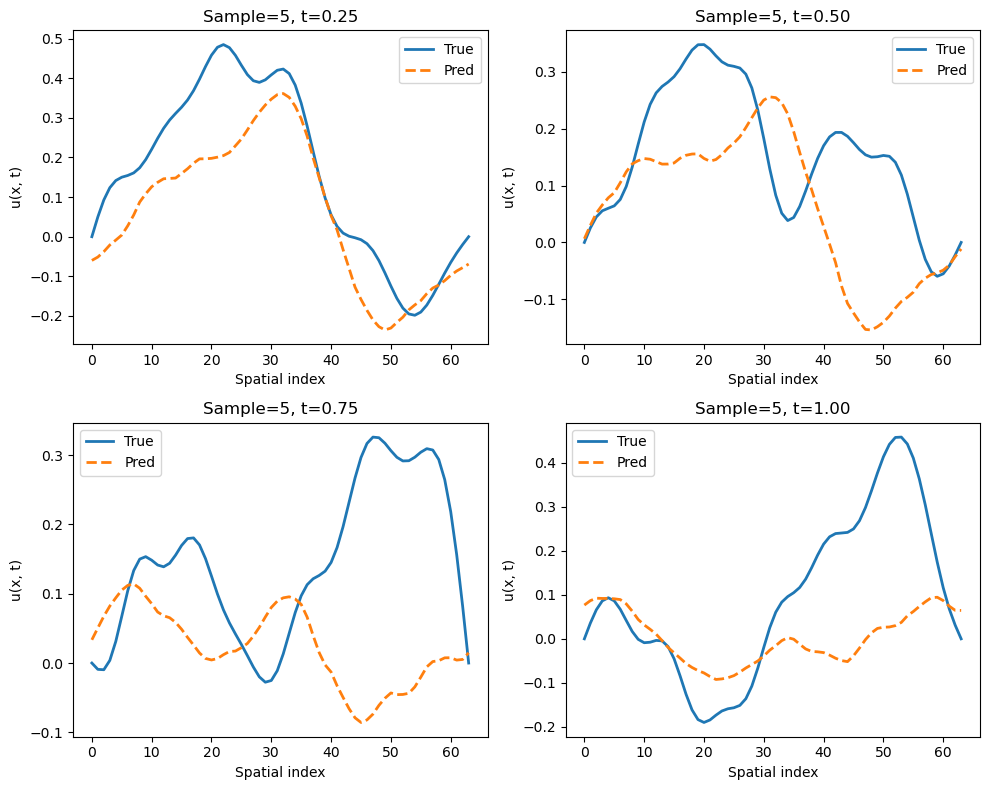

In [ ]:

td_fno.eval()

times = [0.25, 0.5, 0.75, 1.0]
time_indices = [1, 2, 3, 4]

sample_index = 5  
predictions = []
ground_truths = []

for t_idx in time_indices:
    # Create (or reuse) a dataset for this specific t_idx
    dataset = generate_advanced_test_dataset(time_index=t_idx)

    # get only a single sample
    delta_t, inputs, outputs = dataset[sample_index]
    #print("delta_t: ", delta_t)
    
    # => add a batch dimension
    delta_t = delta_t.unsqueeze(0)  # shape: [1]
    inputs = inputs.unsqueeze(0)    # shape: [1, S, 2]
    outputs = outputs.unsqueeze(0)  # shape: [1, S]

    with torch.no_grad():
        # Forward pass
        
        pred = td_fno(inputs, delta_t)
        # pred is shape [1, 1, S], while outputs is [1, S], so match shapes:
        # print("pred shape: ", pred.shape)
        pred = pred.squeeze(1)      # shape [1, S]

    pred_np = pred.squeeze(0).cpu().numpy()    # shape [S]
    true_np = outputs.squeeze(0).cpu().numpy() # shape [S]

    predictions.append(pred_np)
    ground_truths.append(true_np)

# plotting
fig, axes = plt.subplots(2, 2, figsize=(10, 8))

for i, ax in enumerate(axes.flat):
    ax.plot(ground_truths[i], label="True", lw=2)
    ax.plot(predictions[i], label="Pred", lw=2, linestyle="--")
    ax.set_title(f"Sample={sample_index}, t={times[i]:.2f}")
    ax.legend()
    ax.set_xlabel("Spatial index")
    ax.set_ylabel("u(x, t)")

plt.tight_layout()
plt.show()
